In [255]:
# import the requests module
import requests
# import pandas
import pandas as pd
# import json normalize module
from pandas.io.json import json_normalize

# a variable for the API URL - note that we are using v2 - version 2
api_search_url = 'https://api.smk.dk/api/v1/art/search/?keys=sculpture&offset=0&rows=200&lang=en'

# retrieves the response for the URL and parameters we are sending
response = requests.get(api_search_url)

# print the response
print(response)
# the response is 200 - which means all is OK

# retrieve the JSON from the response variable and add to the json variable
json = response.json()

def flatten_json(y):
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out


dic_flattened = [flatten_json(d) for d in json['items']]
df= json_normalize(dic_flattened)

<Response [200]>


In [256]:
#Show the amount of rows and columns in the entire dataframe
print(df.shape)

#Show the amount of cells in the dataframe
print(df.size)

(200, 249)
49800


In [257]:
# Remove coloumns that have don't have atleast 175 rows with non-Nan types
# This gives us an easy overview of columns that we could be interested in
df.dropna(axis=1, thresh=175,inplace=True)

In [258]:
print(df.dtypes)

acquisition_date_precision            object
created                               object
credit_line_0                         object
frame_notes_0                         object
frame_notes_1                         object
has_image                               bool
id                                    object
iiif_manifest                         object
modified                              object
object_names_0_name                   object
object_number                         object
on_display                              bool
production_0_creator                  object
production_0_creator_date_of_birth    object
production_0_creator_lref             object
production_0_creator_nationality      object
production_date_0_end                 object
production_date_0_period              object
production_date_0_start               object
public_domain                           bool
responsible_department                object
rights                                object
titles_0_l

In [259]:
# Creating a new dataframe only consisting of the columns we want
nydf = df[["credit_line_0","has_image",'production_0_creator','production_0_creator_date_of_birth','production_0_creator_nationality','production_date_0_start','production_date_0_end','public_domain','titles_0_language','titles_0_title']]

In [260]:
# renaming columns to more fitting names
nydf.rename(columns={'credit_line_0':'creator','production_0_creator':'name','production_0_creator_date_of_birth':'birthyear','production_0_creator_nationality':'nationality','production_date_0_start':'py_start', 'production_date_0_end':'py_end','titles_0_language':'language','titles_0_title':'title'}, inplace=True)
print(nydf.columns)

Index(['creator', 'has_image', 'name', 'birthyear', 'nationality', 'py_start',
       'py_end', 'public_domain', 'language', 'title'],
      dtype='object')


In [261]:
# Slicing the data of coloumns with dates, to only have a year
nydf.loc[:, 'py_start'] = nydf['py_start'].str[:4]
nydf.loc[:, 'py_end'] = nydf['py_end'].str[:4]
nydf.loc[:, 'birthyear'] = nydf['birthyear'].str[:4]

# Slicing the © and 'space' away from the creator columns
nydf.loc[:, 'creator'] = nydf['creator'].str[2:]


In [262]:
# Changing datatype of 3 columns to numeric:
nydf.loc[:,'py_start'] = pd.to_numeric(nydf['py_start'])
nydf.loc[:,'py_end'] = pd.to_numeric(nydf['py_end'])
nydf.loc[:,'birthyear'] = pd.to_numeric(nydf['birthyear'])
print(nydf.dtypes)
#Count the number of NaN cells in each column
print(nydf.isna().sum())

creator           object
has_image           bool
name              object
birthyear        float64
nationality       object
py_start         float64
py_end           float64
public_domain       bool
language          object
title             object
dtype: object
creator          24
has_image         0
name             18
birthyear        19
nationality      22
py_start         18
py_end           18
public_domain     0
language         13
title            13
dtype: int64


In [263]:
#Printing info about the languages
print('Amount of sculpture titles in a specific language:\n',nydf.language.value_counts())
print('Amount of sculptures without a specified language:\n',nydf.language.isna().sum())

Amount of sculpture titles in a specific language:
 da-DK    177
en-US      6
de-DE      2
fr-FR      2
Name: language, dtype: int64
Amount of sculptures without a specified language:
 13


In [264]:
# New dataframe with count of the artists' birthyear
dfb = pd.DataFrame(nydf['birthyear'].value_counts().reset_index().values,columns=['Birthyear',"Count"])
dfb = dfb.sort_index(axis = 0, ascending=True)
dfb = dfb.astype(int)

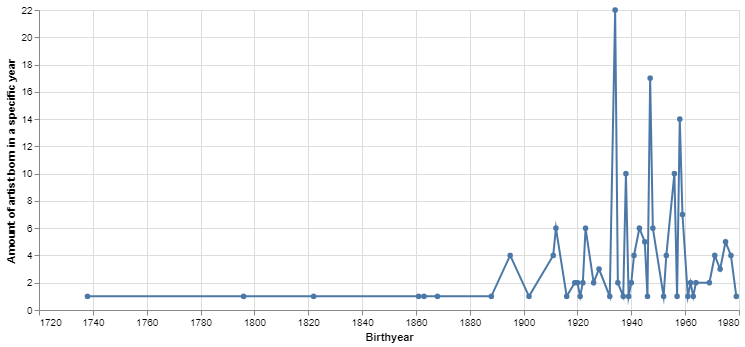

In [265]:
# import the altair code library
import altair as alt
alt.renderers.enable('notebook') # hvis I bruger Jupyter Notebook

# create a line plot
alt.Chart(dfb).mark_line(point=True).encode(
        # Birthyear on the X axis with encoding data type Q for quantitative and format c to display without decimal
        x=alt.X('Birthyear:Q', axis=alt.Axis(format='c', title='Birthyear')),
    
        # Number of artist born in a specific year on the Y axis  with encoding data type Q for quantitative
        y=alt.Y('Count:Q', axis=alt.Axis(title='Amount of artist born in a specific year')),
    
    # determine the width and hight  
    ).properties(width=700, height=300)

In [266]:
# Calculate the artists' age when they created a sculpture
age_when_created = nydf.py_start - nydf.birthyear
# Add the ages as a new column in out dataframe
nydf['Age_when_created'] = age_when_created

C:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [267]:
# New dataframe with count of the artists' age when the sculpture was created
dfb = pd.DataFrame(nydf['Age_when_created'].value_counts().reset_index().values,columns=['Age_when_created',"Count"])
dfb = dfb.sort_index(axis = 0, ascending=True)
dfb = dfb.astype(int)
dfb.head(5)

,Age_when_created,Count
0,68,19
1,36,17
2,37,13
3,58,11
4,35,9


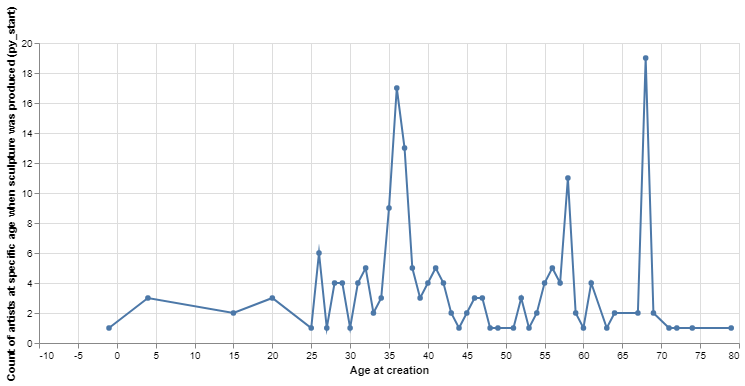

In [268]:
# create a line plot
alt.Chart(dfb).mark_line(point=True).encode(
        # Age_when_created on the X axis with encoding data type Q for quantitative and format c to display without decimal
        x=alt.X('Age_when_created:Q', axis=alt.Axis(format='c', title='Age at creation')),
    
        # Number of artist with a specific age when creating a sculpture on the Y axis  with encoding data type Q for quantitative
        y=alt.Y('Count:Q', axis=alt.Axis(title='Count of artists at specific age when sculpture was produced (py_start)')),
    
    # determine the width and hight  
    ).properties(width=700, height=300)


In [269]:
# Print elements with a value lower than 16 in the 'Age_when_created'-column
print(nydf.loc[nydf['Age_when_created'] < 16])

                         creator  has_image                          name  \
22               Robert Jacobsen       True              Jacobsen, Robert   
102  Jørgen Gudmundsen-Holmgreen      False  Gudmundsen-Holmgreen, Jørgen   
107  Jørgen Gudmundsen-Holmgreen      False  Gudmundsen-Holmgreen, Jørgen   
121  Jørgen Gudmundsen-Holmgreen      False  Gudmundsen-Holmgreen, Jørgen   
124  Jørgen Gudmundsen-Holmgreen      False  Gudmundsen-Holmgreen, Jørgen   
151               Bjørn Nørgaard       True               Nørgaard, Bjørn   

     birthyear nationality  py_start  py_end  public_domain language  \
22      1912.0       dansk    1927.0  1981.0          False    da-DK   
102     1895.0       dansk    1899.0  1952.0          False    da-DK   
107     1895.0       dansk    1894.0  1965.0          False    da-DK   
121     1895.0       dansk    1899.0  1946.0          False    da-DK   
124     1895.0       dansk    1899.0  1952.0          False    da-DK   
151     1947.0       dansk  

In [270]:
# Calculate the artists' age when they created a sculpture
age_when_created2 = nydf.py_end - nydf.birthyear
# Add the ages as a new column in out dataframe
nydf['Age_when_created2'] = age_when_created2
# New dataframe with count of the artists' age when the sculpture was created
dfb2 = pd.DataFrame(nydf['Age_when_created2'].value_counts().reset_index().values,columns=['Age_when_created2',"Count"])
dfb2 = dfb2.sort_index(axis = 0, ascending=True)
dfb2 = dfb2.astype(int)
dfb2.head(5)

C:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Age_when_created2,Count
0,36,27
1,70,20
2,39,18
3,58,10
4,57,7


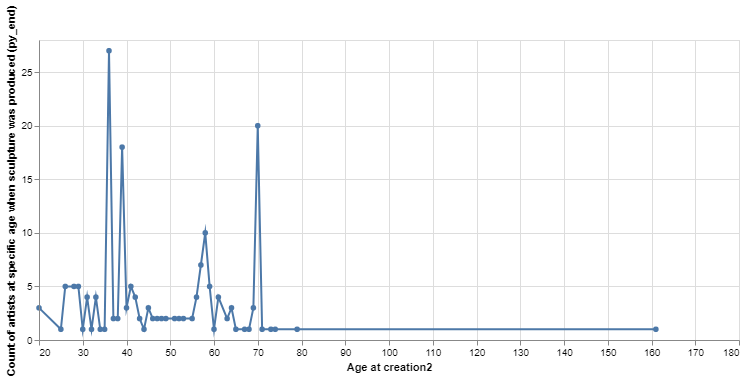

In [271]:
# create a line plot
alt.Chart(dfb2).mark_line(point=True).encode(
        # Age_when_created on the X axis with encoding data type Q for quantitative and format c to display without decimal
        x=alt.X('Age_when_created2:Q', axis=alt.Axis(format='c', title='Age at creation2')),
    
        # Number of artist with a specific age when creating a sculpture on the Y axis  with encoding data type Q for quantitative
        y=alt.Y('Count:Q', axis=alt.Axis(title='Count of artists at specific age when sculpture was produced (py_end)')),
    
    # determine the width and hight  
    ).properties(width=700, height=300)

In [272]:
# Calculate the artists' age when they created a sculpture
years_to_create = nydf.py_end - nydf.py_start
# Add the ages as a new column in out dataframe
nydf['time_to_produce'] = years_to_create
print(nydf.loc[nydf['time_to_produce'] > 5])

                         creator  has_image                          name  \
22               Robert Jacobsen       True              Jacobsen, Robert   
70                           NaN       True             Maillol, Aristide   
102  Jørgen Gudmundsen-Holmgreen      False  Gudmundsen-Holmgreen, Jørgen   
107  Jørgen Gudmundsen-Holmgreen      False  Gudmundsen-Holmgreen, Jørgen   
117                 Willy Ørskov      False                 Ørskov, Willy   
121  Jørgen Gudmundsen-Holmgreen      False  Gudmundsen-Holmgreen, Jørgen   
124  Jørgen Gudmundsen-Holmgreen      False  Gudmundsen-Holmgreen, Jørgen   
150              Richard Winther       True              Winther, Richard   
151               Bjørn Nørgaard       True               Nørgaard, Bjørn   
164              Richard Winther      False              Winther, Richard   
190         Sonja Ferlov Mancoba      False         Ferlov Mancoba, Sonja   

     birthyear nationality  py_start  py_end  public_domain language  \
22 

C:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
